In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches
import json
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'Replica, same place',
    'Same device type in different place': 'Same room, different place',
    'Same device in different place': 'Same room, different place',
    'Same device type across spaces': 'Different room',
    'Same device across spaces': 'Different room',
    'Same device in same place': '__remove__',
    'No transfer': 'No transfer'
})
df = df.loc[df.type_of_transfer != '__remove__']

df_mites = df.loc[df.source_device_type == 'Mite']
df_mites = df_mites.loc[df_mites.target_device_type == 'Mite']
df_no_transfer = df.loc[df.type_of_transfer == 'No transfer']

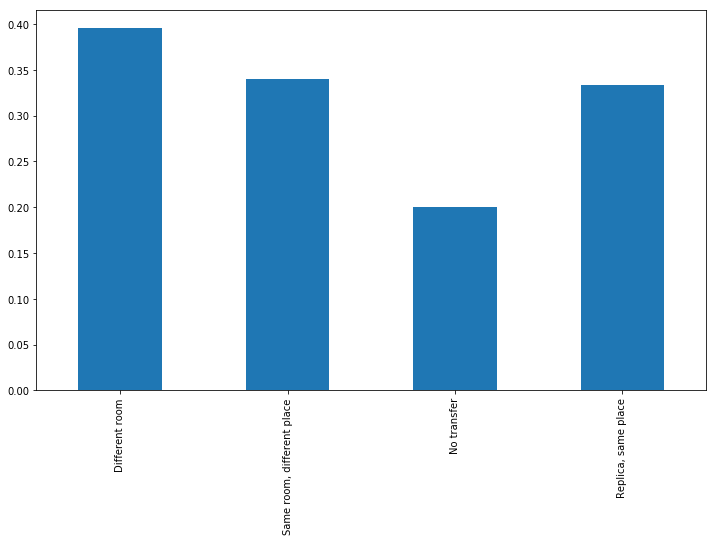

In [3]:
considered = df
considered = considered.loc[considered.specificity < 0.95]
(considered.type_of_transfer.value_counts() / df.type_of_transfer.value_counts()).plot.bar()

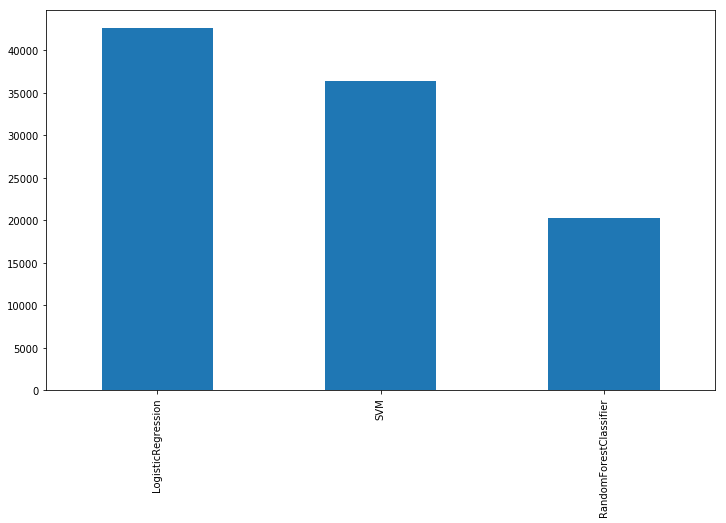

In [17]:
considered.classifier.value_counts().plot.bar()

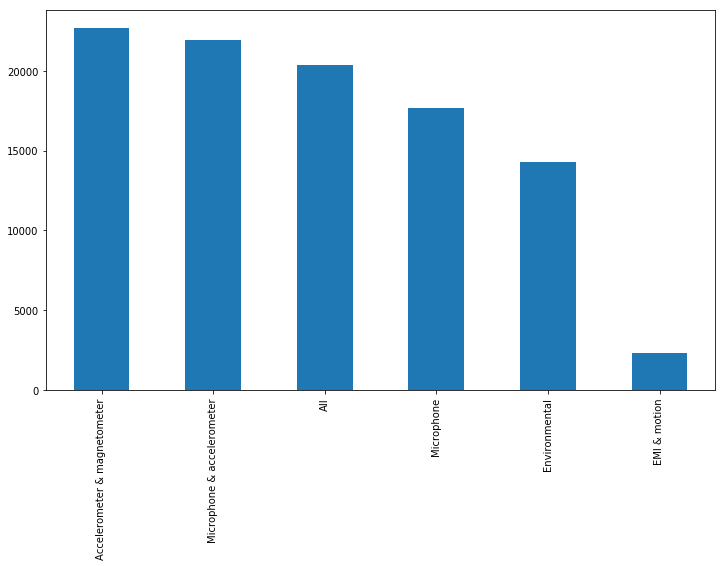

In [18]:
considered.features_name.value_counts().plot.bar()

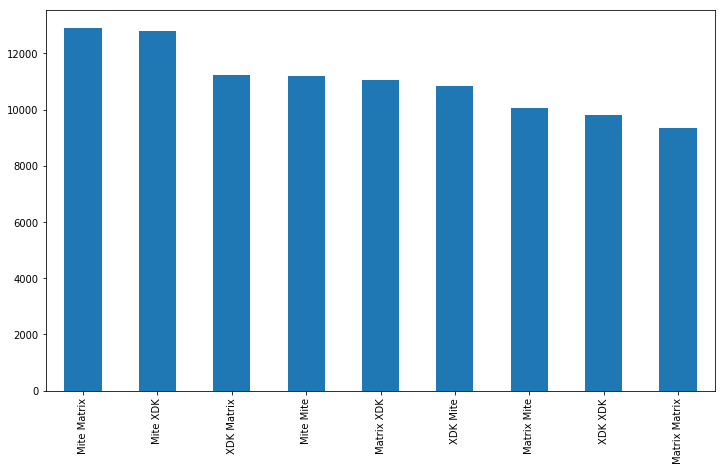

In [21]:
(considered.source_device_type + ' ' + considered.target_device_type).value_counts().plot.bar()

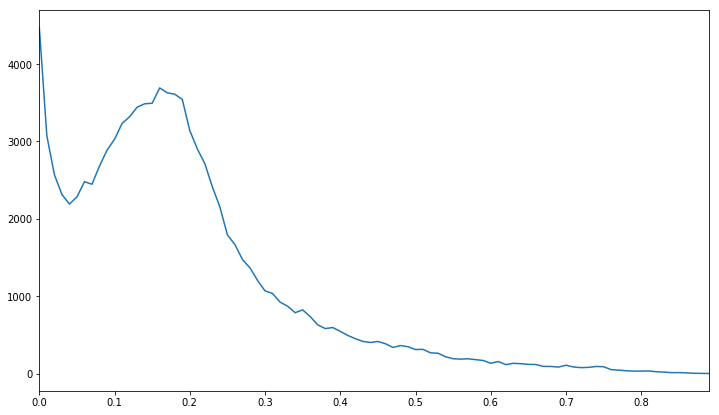

In [33]:
considered.f1.round(2).value_counts().sort_index().plot()

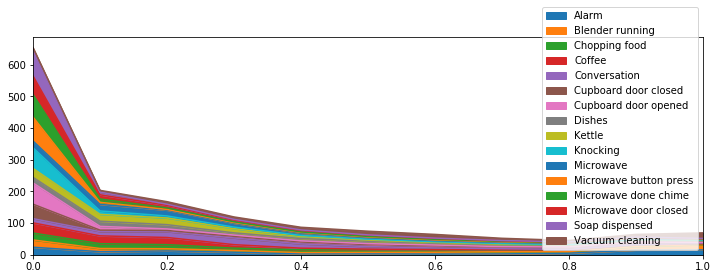

In [5]:
def plots_by(df, column, normalize=True, round_to=1, classifier=None, features=None, ax=None, title=None):
    if classifier is not None:
        df = df.loc[df.classifier == classifier]
    if features is not None:
        df = df.loc[df.features_name == features]
    new_df = {}
    for val in df[column].unique():
        subdf = df.loc[df[column] == val]
        value_counts = subdf.f1.round(round_to).value_counts().sort_index()
        if normalize:
            value_counts = value_counts / value_counts.sum()
            value_counts *= 100
        new_df[val] = value_counts
    pd.DataFrame(new_df).plot.area(ax=ax)
    if ax is not None:
        matplotlib.pyplot.sca(ax)
    if title is not None:
        plt.title(title)

plots_by(df_mites, 'label')

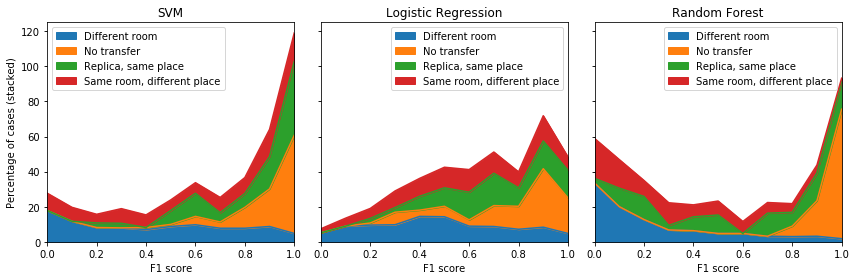

In [8]:
plt.rcParams["figure.figsize"] = (12, 4)

plot_df = df_mites
# plot_df = plot_df.loc[plot_df.type_of_transfer == 'Same room, different place']

plot_df = plot_df.loc[plot_df.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]

f, axes = plt.subplots(1, 3, sharex=False, sharey=True)

plots_by(plot_df, 'type_of_transfer', normalize=True, round_to=1, classifier='SVM', features='All', ax=axes[0], title='SVM')
plt.xlabel('F1 score')
plt.ylabel('Percentage of cases (stacked)')
plots_by(plot_df, 'type_of_transfer', normalize=True, round_to=1, classifier='LogisticRegression', features='All', ax=axes[1], title='Logistic Regression')
plt.xlabel('F1 score')
plots_by(plot_df, 'type_of_transfer', normalize=True, round_to=1, classifier='RandomForestClassifier', features='All', ax=axes[2], title='Random Forest')
plt.xlabel('F1 score')

plt.tight_layout()

plt.savefig('../plots/classifier_performance_distribution.pdf')
plt.show()

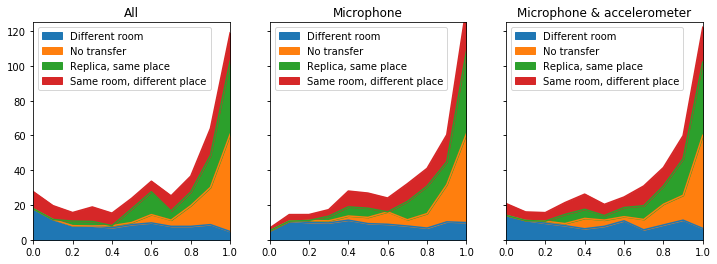

In [82]:
plt.rcParams["figure.figsize"] = (12, 4)

plot_df = df_mites
# plot_df = plot_df.loc[plot_df.type_of_transfer == 'Same room, different place']

plot_df = plot_df.loc[plot_df.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]

f, axes = plt.subplots(1, 3, sharex=False, sharey=True)

plots_by(plot_df, 'type_of_transfer', normalize=True, round_to=1, classifier='SVM', features='All', ax=axes[0], title='All')
plots_by(plot_df, 'type_of_transfer', normalize=True, round_to=1, classifier='SVM', features='Microphone', ax=axes[1], title='Microphone')
plots_by(plot_df, 'type_of_transfer', normalize=True, round_to=1, classifier='SVM', features='Microphone & accelerometer', ax=axes[2], title='Microphone & accelerometer')

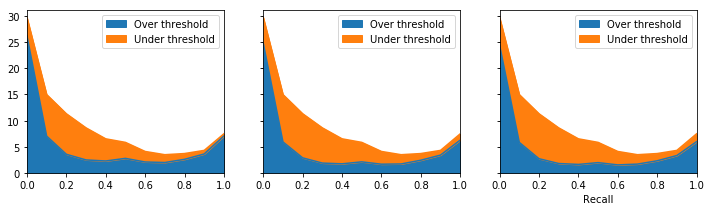

In [11]:
plt.rcParams["figure.figsize"] = (12, 3)


plot_df = df
# plot_df = plot_df.loc[plot_df.type_of_transfer == 'Same room, different place']

plot_df = plot_df.loc[plot_df.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]
# plot_df = plot_df.loc[plot_df.classifier == 'SVM']
# plot_df = plot_df.loc[plot_df.features_name == 'All']

def normalize(series, divide_by_series):
    value_counts = series.round(1).value_counts()
    divide_by_value_counts = divide_by_series.round(1).value_counts()
    value_counts = value_counts / divide_by_value_counts.sum()
    value_counts *= 100
    return value_counts

f, axes = plt.subplots(1, 3, sharex=False, sharey=True)

threshold = 0.95
pd.DataFrame({
    'Over threshold': normalize(plot_df.loc[plot_df.specificity_1 >= threshold].recall, plot_df.recall),
    'Under threshold': normalize(plot_df.loc[plot_df.specificity_1 < threshold].recall, plot_df.recall)
}).plot.area(ax=axes[0])
plt.ylabel('Percentage of cases')
plt.xlabel('Recall')

# threshold = 0.97
pd.DataFrame({
    'Over threshold': normalize(plot_df.loc[plot_df.specificity_2 >= threshold].recall, plot_df.recall),
    'Under threshold': normalize(plot_df.loc[plot_df.specificity_2 < threshold].recall, plot_df.recall)
}).plot.area(ax=axes[1])
plt.ylabel('Percentage of cases')
plt.xlabel('Recall')

# threshold = 0.98
pd.DataFrame({
    'Over threshold': normalize(plot_df.loc[plot_df.specificity_3 >= threshold].recall, plot_df.recall),
    'Under threshold': normalize(plot_df.loc[plot_df.specificity_3 < threshold].recall, plot_df.recall)
}).plot.area(ax=axes[2])
plt.ylabel('Percentage of cases')
plt.xlabel('Recall')

In [9]:
df_classified = pd.read_pickle('results_with_accuracy_classified_s5.p')
df_classified = df_classified.loc[df_classified.predictions >= 0]

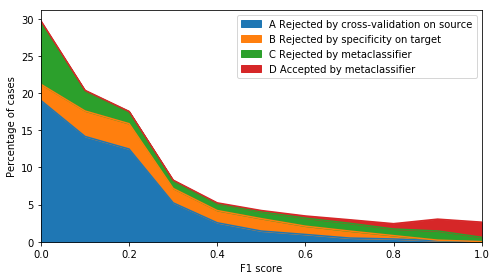

In [17]:
plt.rcParams["figure.figsize"] = (7, 4)


plot_df = df_classified
# plot_df = plot_df.loc[plot_df.f1_wt >= 0.75]
# plot_df = plot_df.loc[plot_df.source_device_type == 'Mite']
# plot_df = plot_df.loc[plot_df.target_device_type == 'Mite']
# plot_df = plot_df.loc[plot_df.type_of_transfer == 'Same room, different place']

plot_df = plot_df.loc[((plot_df.source_device_type == 'Mite') & (plot_df.target_device_type == 'Mite') | (plot_df.source_device_type != plot_df.target_device_type))]

plot_df = plot_df.loc[plot_df.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]

divide_by = plot_df
# plot_df = plot_df.loc[plot_df.f1 >= 0.35]

source_threshold = 0.75
threshold = 0.95
under_source_threshold = plot_df.loc[plot_df.f1_wt < source_threshold]
over_source_threshold = plot_df.loc[plot_df.f1_wt >= source_threshold]
under_threshold = over_source_threshold.loc[over_source_threshold.specificity_3 < threshold]
over_threshold = over_source_threshold.loc[over_source_threshold.specificity_3 >= threshold]

pd.DataFrame({
    'A Rejected by cross-validation on source': normalize(under_source_threshold.f1, divide_by.f1),
    'B Rejected by specificity on target': normalize(under_threshold.f1, divide_by.f1),
    'D Accepted by metaclassifier': normalize(over_threshold.loc[over_threshold.predictions >= 1].f1, divide_by.f1),
    'C Rejected by metaclassifier': normalize(over_threshold.loc[over_threshold.predictions == 0].f1, divide_by.f1)
}).plot.area()
plt.ylabel('Percentage of cases')
plt.xlabel('F1 score')
# plt.title('Zoomed in')

plt.tight_layout()
plt.savefig('../plots/distribution_of_model_performances.pdf')
plt.show()